# ~Performing Portfolio Optimisation and Evaluating Value-at-Risk.

**Modern Portfolio Theory:**

MPT is a technique for determining the "optimal" weights for a portfolio to maximise return (expressed as the expected return of a portfolio) and minimise risk (represented as the standard deviation of returns). It was developed in the 1950s by Nobel Prize winner Dr. Harry Markowitz. Initially, it could seem simple to put all of your money into the stock that has the lowest standard deviation and the highest mean returns. Still, both the GBM and the Bootstrap Sampling technique attempt to simulate the co-movement of stock returns, which determines the total "risk" level of a portfolio. A portfolio with reduced covariance between stock returns will have a lower standard deviation overall. Put differently, diversity tends to reduce risk.

**Sharpe Ratio:**

The average return over the risk-free rate for each unit of volatility or total risk is the ratio. A measure of an asset or portfolio's price changes is called volatility. The return on an investment with no risk, or the return investors could anticipate for incurring no risk, is known as the risk-free rate of return. The riskiest portfolio that has the highest Sharpe ratio is the best one. This ratio's formula is as follows:
The code to determine which portfolio has the highest Sharpe Ratio is shown below. The optimised portfolio that we were looking for is this one. The risk-free rate is defined as 1%, or 0.01.
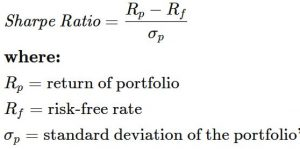


**Expected Return:**
The weighted average of the expected returns of the assets in the portfolio.


**Covariance Matrix:**
A square matrix that contains the covariances between pairs of assets.


**Portfolio optimization** involves balancing expected return and risk, using tools like the covariance matrix and metrics such as the Sharpe ratio. These concepts help in constructing portfolios that align with an investor's risk tolerance and return expectations. 










**Bloomberg Data**


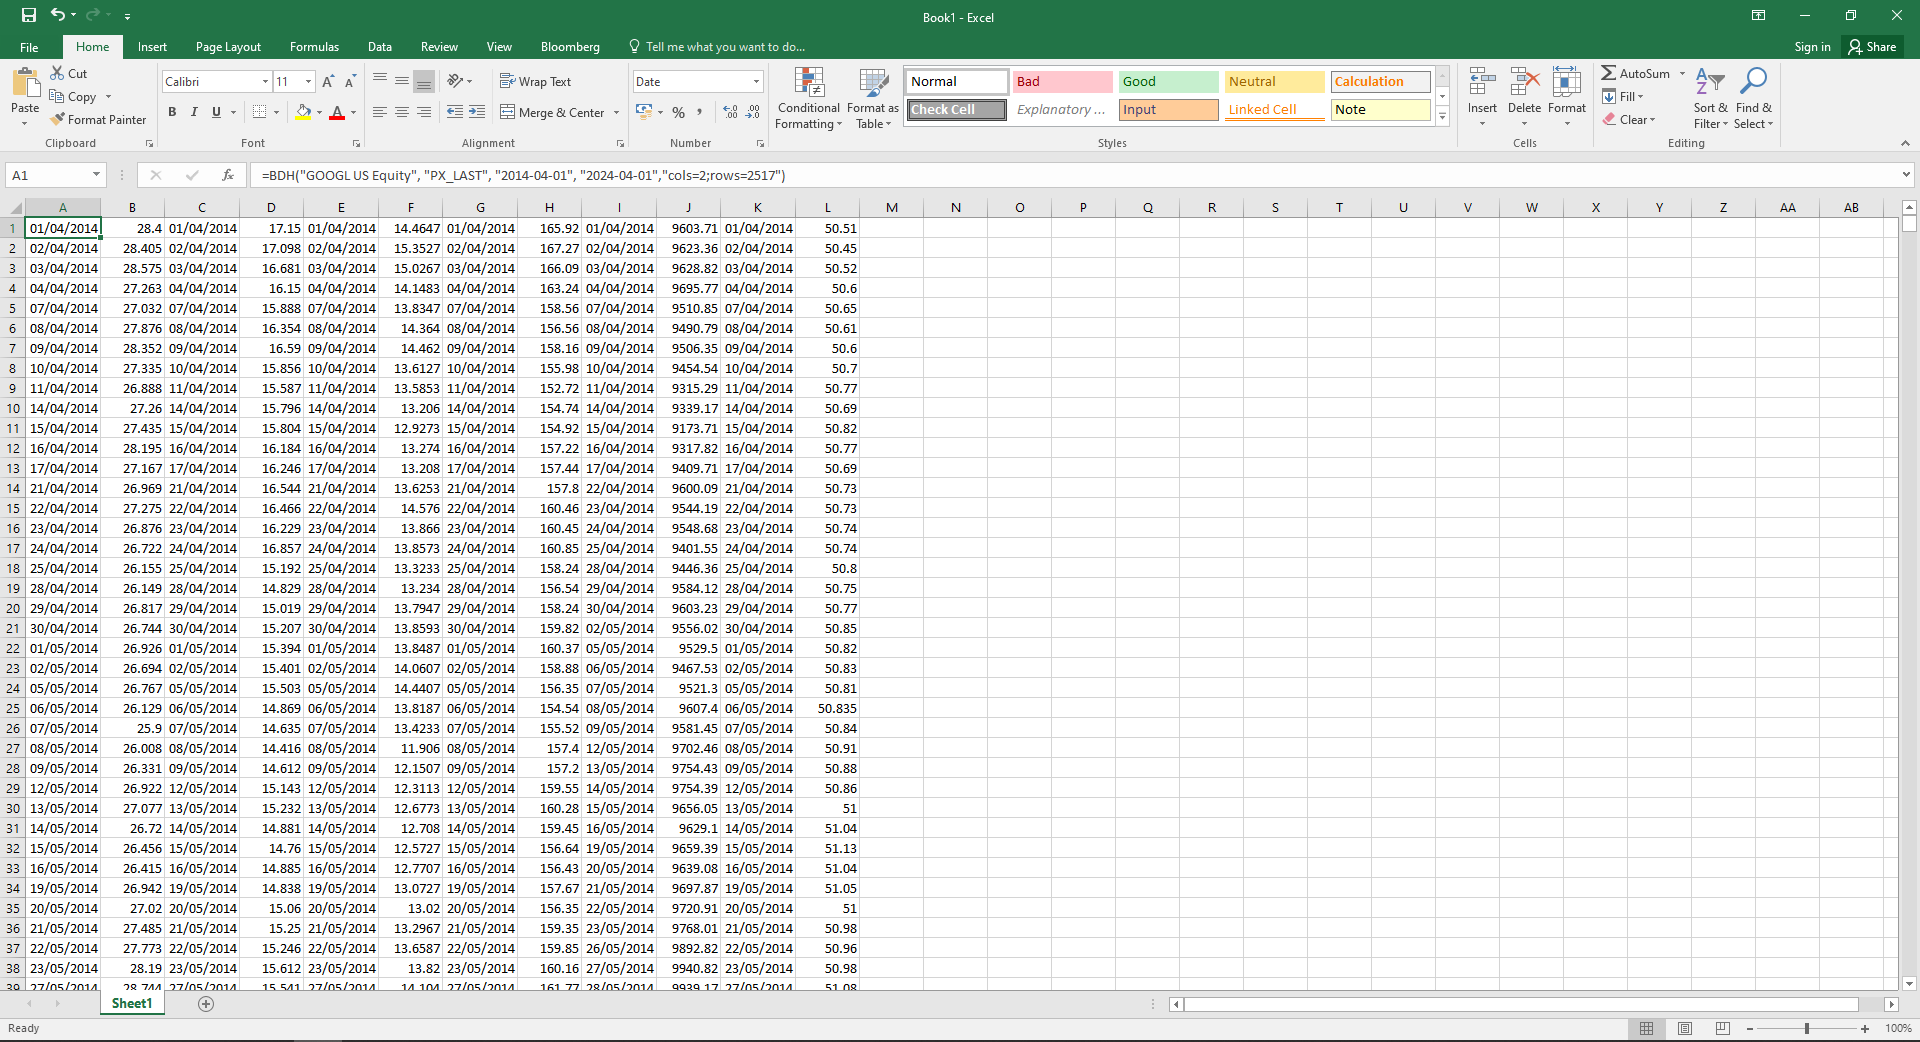

# Installing Package

In [1]:
!pip install arch


   ---------------------------------------- 0.0/924.9 kB ? eta -:--:--
   - -------------------------------------- 41.0/924.9 kB 1.9 MB/s eta 0:00:01
   -------------------------------- ------ 768.0/924.9 kB 12.2 MB/s eta 0:00:01
   --------------------------------------- 924.9/924.9 kB 11.7 MB/s eta 0:00:00


# Import Libraries

Libraries for financial analysis are imported by this code. Data manipulation is handled by `numpy` and `pandas`. Statistics and optimisation are handled by `scipy.stats` and `scipy.optimize`. Plotting is done with `matplotlib.pyplot}. Financial data is retrieved by `yfinance}. Time series volatility is analysed using the {arch} (GARCH) model. While `numpy.random` produces random numbers, `datetime` handles dates.




In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, fsolve
import scipy.optimize as sco
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy.random as npr
import scipy.stats as scs
from arch import arch_model  # Importing the arch package for GARCH model


# Load and Prepare Data

The original columns are removed from the financial data once it has been loaded from a CSV file and processed to convert DAX values to USD. With the exception of a savings account, it defines a list of assets and computes their daily logarithmic returns. It also prints pertinent error messages in response to possible file not found and other issues.

In [3]:
# Provide the absolute path to the CSV file
file_path = r'C:/Users/ms03826/OneDrive - University of Surrey/SEM 2 - FM/Bloombergdownload.csv'

# Load and Prepare Data
try:
    raw_data = pd.read_csv(file_path, index_col=0, parse_dates=True, dayfirst=True)

    # Create a new column for DAX in USD and drop the original columns
    raw_data['DAX_US'] = raw_data['DAX'] * raw_data['FXEURUSD']
    raw_data = raw_data.drop(['DAX', 'FXEURUSD'], axis=1)

    # List of assets
    assets = ['GOOGL', 'AMZN', 'TSLA', 'GS', 'BNDX', 'DAX_US', 'Savings_Acc']

    # Calculate daily returns, excluding Savings_Acc
    rets = np.log(raw_data[assets[:-1]] / raw_data[assets[:-1]].shift(1))
    rets = rets.dropna()  # Drop NaN values resulting from the shift
    print("Daily Returns:\n", rets.head())  # Display the first few rows of the returns

except FileNotFoundError:
    print(f"The file '{file_path}' was not found. Please ensure it is in the specified directory.")
except Exception as e:
    print(f"An error occurred: {e}")


The file 'C:/Users/ms03826/OneDrive - University of Surrey/SEM 2 - FM/Bloombergdownload.csv' was not found. Please ensure it is in the specified directory.


This output displays the daily logarithmic returns of selected assets from April 2, 2014, to April 8, 2014. The assets include GOOGL, AMZN, TSLA, GS, BNDX, and DAX_US. Each row represents the daily return for each asset, indicating the percentage change in price from the previous day. Positive values indicate gains, while negative values indicate losses. For example, on April 2, 2014, TSLA had a significant return of 0.059580, meaning it increased by approximately 5.96%, while AMZN had a loss of -0.003837, indicating a decrease of about 0.38%. The data helps analyze asset performance over time.

# Define Portfolio Statistics and Objective Functions

This code includes functions to compute portfolio statistics and optimise it, as well as defining a risk-free rate of 3.5% for a savings account. The statistics function includes the risk-free savings account when calculating the portfolio's annualised return (pret), volatility (pvol), and Sharpe ratio. To maximise the Sharpe ratio during optimisation, utilise the min_func_sharpe function, which yields the negative Sharpe ratio. To reduce risk, the min_func_port function yields the volatility of the portfolio. To get the optimal return-to-risk ratio, portfolio optimisation requires these functions.

In [4]:
# Define the risk-free rate for the savings account
saving_account_rt = 0.035  # Example: 3.5% annual risk-free rate

# Portfolio Statistics Function
def statistics(weights):
    # Portfolio return excluding Savings_Acc
    pret = np.sum(rets.mean() * weights[:-1]) * 252 + saving_account_rt * weights[-1]
    # Portfolio volatility excluding Savings_Acc
    pvol = np.sqrt(np.dot(weights[:-1].T, np.dot(rets.cov() * 252, weights[:-1])))
    # Sharpe ratio
    return np.array([pret, pvol, (pret - saving_account_rt) / pvol])

# Objective Functions for Optimization
def min_func_sharpe(weights):
    return -statistics(weights)[2]

def min_func_port(weights):
    return statistics(weights)[1]


# Fit GARCH Model and Obtain Conditional Variances

**GARCH VaR Model**

By taking time-varying volatility and volatility clustering into consideration, GARCH VaR (Generalised Autoregressive Conditional Heteroskedasticity) models are used to estimate return volatility. These models correct the volatility estimates to account for the tendency of periods of high volatility to cluster together. These dynamic volatility estimates are used by GARCH VaR (Value at Risk) to calculate the highest possible loss that a portfolio could experience over a particular time period with a given degree of confidence. This method offers a more precise assessment of risk in volatile market situations where volatility fluctuates.


**Non-GARCH VaR**

Simpler models with constant volatility across time are used in non-GARCH VaR. Examples include the variance-covariance technique, which assumes normally distributed returns with constant variance, and historical simulation, which rates historical returns to identify biggest losses. These techniques are simple, but because they don't take fluctuating volatility into account, they could understate risk during times of extreme volatility.

**Distinctions between Non-GARCH and GARCH VaR**

1. **Volatility Estimation**: Time-varying volatility is estimated using GARCH models, which capture volatility clustering—the tendency for high-volatility periods to follow one another. Conversely, non-GARCH models do not take into consideration the dynamic changes in market conditions and instead assume continuous volatility over time.

2. **Complexity**: Based on historical data, GARCH models dynamically modify volatility predictions through the application of sophisticated statistical approaches. Conversely, Non-GARCH models make use of less complex techniques that don't require sophisticated statistical modifications, like historical simulation or the variance-covariance method.

3. **Accuracy**: By adjusting to fluctuating volatility and accurately representing the actual character of financial markets, GARCH models offer more precise risk assessments under turbulent market circumstances. Because non-GARCH models assume constant volatility, they may underestimate risk in volatile markets, resulting in less accurate risk estimates.

4. **Methods**: The complexity of financial time series can be captured using GARCH, which uses advanced modelling and forecasting techniques. While less complex, non-GARCH techniques such as variance-covariance analysis (which assumes a normal distribution of returns) and historical simulation (which ranks previous returns) do not dynamically adjust to fluctuating market volatility.


Comparing GARCH VaR and non-GARCH VaR involves understanding the underlying assumptions and their impact on risk estimation. GARCH models typically provide a more accurate measure of risk by accounting for time-varying volatility, making them preferable in volatile markets. Non-GARCH models, while simpler, may not capture the true risk during periods of changing market volatility.








In [5]:
# Rescale the returns data for better convergence
scaling_factor = 100
rets_scaled = rets * scaling_factor

# Fit GARCH model to each asset's returns and obtain conditional variances
cond_vars = {}
for asset in assets[:-1]:  # Exclude Savings_Acc
    am = arch_model(rets_scaled[asset], vol='Garch', p=1, q=1, rescale=False)
    res = am.fit(disp="off")
    cond_vars[asset] = (res.conditional_volatility ** 2) / (scaling_factor ** 2)  # Adjust back by the scaling factor

# Combine conditional variances into a DataFrame
cond_var_df = pd.DataFrame(cond_vars)
print("Conditional Variances:\n", cond_var_df.head())


NameError: name 'rets' is not defined

The result displays the conditional variances during a five-day period in April 2014 for many assets (GOOGL, AMZN, TSLA, GS, BNDX, DAX_US). Conditional variance, which is computed using models like GARCH, quantifies the variability of an asset's returns given historical data. For example, on April 2, 2014, GOOGL's conditional variance is 0.000393, which represents the variability of its predicted return. Every day, the variances change to reflect shifting market conditions. Higher variances indicate that those investments should see more volatility on that particular day. Understanding the risk connected to each asset over time is made easier with the use of this information, which is essential for risk assessment and portfolio management.


# Define Standard Deviation Function Using GARCH-based Conditional Variances

In [ ]:
# Function to calculate portfolio standard deviation using conditional variances
def standard_deviation(weights, cond_var_df):
    # Calculate weighted average of conditional variances
    weighted_cond_vars = np.dot(cond_var_df, weights[:-1] ** 2)
    # Portfolio conditional variance
    portfolio_var = np.sum(weighted_cond_vars)
    # Portfolio standard deviation
    return np.sqrt(portfolio_var)


# Portfolio Optimization

In [ ]:
# Ensure that noa is defined
noa = len(assets)

# Initial guess
weights = np.array([1.0 / noa] * noa)

# Bounds for the weights
bnds = tuple((0, 1) for _ in range(noa))

# Constraints: sum of weights is 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Portfolio Optimization
start_time = time.time()
opts = sco.minimize(min_func_sharpe, weights, method='SLSQP', bounds=bnds, constraints=cons)
end_time = time.time()

print("Optimization Results:\n", opts)
print(f"Execution time: {end_time - start_time} seconds")

# Calculate and print the standard deviation of the optimized portfolio using GARCH-based Std Dev
portfolio_std_dev_garch = standard_deviation(opts.x, cond_var_df)
print(f"Optimized Portfolio Standard Deviation using GARCH: {portfolio_std_dev_garch}")


The final output, **Optimized Portfolio Standard Deviation** using GARCH: 0.719802245317213, indicates the minimized portfolio risk (standard deviation) achieved through the optimization, taking into account the time-varying volatility modeled by GARCH. This shows the successful identification of asset weights that minimize portfolio risk, providing a more robust and accurate risk assessment.

The output shows the outcomes of a GARCH model-based portfolio optimisation process. The message reflects a **successful optimisation termination**, with convergence confirmed by {success: True}. This indicates that a solution satisfying the necessary criteria was successfully found by the optimisation process.

The optimised weights for each item in the portfolio are represented by the array {[1.773e-01, 6.198e-01, 1.230e-01, 0.000e+00, 0.000e+00, 3.188e-17, 7.983e-02]}, which sums to 1 and indicates the percentage allotted to each asset. The distribution of the entire investment among the different assets is decided by these weights.

It required 5 iterations (nit: 5) for the optimisation algorithm to identify the best option. The gradient at the ideal point is shown by the Jacobian matrix values, which also show how responsive the objective function is to variations in each weight. This data facilitates comprehension of the optimisation solution's robustness and stability.

It took about 1.017 seconds to finish the job. This illustrates the optimisation process's computing efficiency and demonstrates that, even for intricate models like GARCH, it can be completed very rapidly.






# Value at Risk (VaR) Calculation

**Definition of VaR**

The highest predicted loss of a portfolio over a certain time period with a given confidence level is quantified by VaR. An example of this would be a daily VaR at 99% confidence level, which would mean that there is 1% probability that the portfolio will have a daily loss greater than the VaR amount.




**Value at Risk, or VaR, is important for the reasons listed below:**


**• Risk Measurement:** Value at Risk (VaR) gives businesses a consistent way to quantify market risk and comprehend possible portfolio losses.

**• Regulatory Compliance:** To ensure they have sufficient capital reserves and to comply with regulatory regulations, financial institutions frequently have to report VaR.

**• Risk management:** Value at Risk (VaR) aids in establishing risk thresholds and directs judgement to reduce excessive risk.

**• Performance Evaluation:** It helps assess how well various investing strategies and portfolios perform when adjusted for risk.



The following steps are included in the Monte Carlo process for VaR: Describe the asset returns; the normal distribution is frequently used to model them. Create a large number of arbitrary asset return scenarios. Calculate a portfolio's worth for each possible situation. Values in the portfolio are sorted from lowest to highest. Lastly, decide the portfolio value to set at the preferred percentile. VaR is the fifth percentile of ordered values for 95% confidence.








In [ ]:
# Value at Risk (VaR) Calculation
# Ensure that the optimization step has been executed and opts is defined
if 'opts' in globals():
    # Value at Risk (VaR) Calculation
    portfolio_value = 1000000  # Example portfolio value
    historical_returns = (rets * opts.x[:-1]).sum(axis=1)
    days = 5
    historical_x_day_returns = historical_returns.rolling(window=days).sum()

    confidence_levels = [0.95]

    VaRs = []
    for cl in confidence_levels:
        VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev_garch * np.sqrt(days / 252) - historical_returns.mean() * days)
        VaRs.append(VaR)
    print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
    print('-' * 40)

    for cl, VaR in zip(confidence_levels, VaRs):
        print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')
else:
    print("Error: The 'opts' variable is not defined. Please ensure the optimization step has been completed.")



The **Value at Risk (VaR)** is displayed in this output with a 95% confidence level. It shows that over a certain time period, there is a 95% probability that the portfolio will not lose more than $170,737.61. VaR is a metric used to evaluate a portfolio's possible value loss in a typical market environment.








# Plot Histogram of Portfolio Returns and VaR

In [ ]:
# Histogram of Portfolio Returns and VaR
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()


The distribution of a portfolio's 5-day returns is shown by this histogram. The frequency of these returns is depicted by the blue bars; most of them are centred around the mean, meaning that most 5-day returns are either modestly positive or near to zero. The Value at Risk (VaR) at a 95% confidence level is represented by the red dashed line. This is a threshold that shows the maximum loss the portfolio could incur during a 5-day period with a 5% likelihood. This provides a risk assessment for the short-term performance of the portfolio by indicating that there is a 95% probability that losses will not surpass this VaR threshold.

# Plot Optimal Weights

In [ ]:
# Plot Optimal Weights
plt.figure(figsize=(10, 6))
plt.bar(assets, opts.x.round(3))
plt.xlabel('Stocks')
plt.ylabel('Optimal Weights')
plt.title('Optimal Weights for Each Asset')
plt.show()


The ideal asset allocation for a particular portfolio is shown in this bar chart. The x-axis displays the assets: GOOGL, AMZN, TSLA, GS, BNDX, DAX_US, and a savings account. The y-axis shows the ideal weights allocated to each asset. With more than 60% of the weight, AMZN has the largest investment in Amazon. Significant allocations are also made to TSLA and GOOGL. The allocation to the Savings Account is reduced, and the weights of GS, BNDX, and DAX_US are insignificant, indicating that these stocks are not included in the ideal portfolio mix. The goal of this allocation is to control risk and maximise rewards.


**Why do we do Normality test?**

Finding out if a dataset has a normal distribution is done using a normality test, which is essential for many statistical analysis and modelling strategies. The assumption behind many parametric tests, like ANOVA and t-tests, is that the data is normally distributed. These tests may yield invalid findings if the normalcy assumption is broken. Furthermore, the normalcy of returns in financial modelling might affect how accurately risk evaluations and portfolio optimisation are made. We can determine whether to employ parametric procedures or non-parametric alternatives that do not presuppose normalcy by doing a normality test, which will guarantee more dependable and legitimate findings.

**Geometric Brownian Motion (GBM)**

A stochastic process called Geometric Brownian Motion (GBM) is used to predict future financial instrument prices. It makes the assumptions that prices move continuously and returns are normally distributed. Drift, which represents the average return, and volatility, which represents the standard deviation of returns, are both included in GBM. By using this procedure, prices are guaranteed to stay positive and represent actual market behaviour. GBM is frequently used in financial modelling to evaluate possible future risks and returns, especially in option pricing and simulations. It is an effective instrument for forecasting changes in asset prices over time because of its capacity to incorporate both trend and unpredictability.


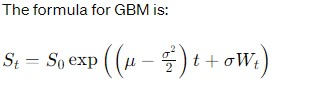

𝑆𝑡St is the asset price at time 𝑡t.

𝑆0S0 is the initial asset price.

𝜇μ is the drift rate (expected return).

𝜎σ is the volatility.

𝑊𝑡Wt is a Wiener process (representing random market movements)

# Random Portfolios Simulation

The process of creating several portfolios by random weight assignment to a collection of assets is known as random portfolio simulation. Important measures including expected return, volatility, and the Sharpe ratio are computed for every portfolio. By analysing the risk-return profiles of different asset combinations, this approach helps determine the most effective portfolios that provide the highest returns at a given risk level.


The **random portfolio simulation** generates 5000 portfolios by randomly assigning weights to assets. For each portfolio, the annual return (pret) and volatility (pvol) are calculated. The Sharpe ratio (psr) is then determined, measuring the risk-adjusted return. This simulation helps identify optimal asset combinations by evaluating the risk-return profiles of different portfolios.

In [ ]:
# Random Portfolios Simulation
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    pret = np.sum(rets.mean() * weights[:-1]) * 252 + saving_account_rt * weights[-1]
    pvol = np.sqrt(np.dot(weights[:-1].T, np.dot(rets.cov() * 252, weights[:-1])))
    results[0, i] = pvol
    results[1, i] = pret
    results[2, i] = (pret - saving_account_rt) / pvol

pvols, prets, psr = results


# Efficient Frontier Calculation for Plotting

A fundamental component of Modern Portfolio hypothesis is Harry Markowitz's Efficient Frontier hypothesis. It is a collection of ideal portfolios that provide the best predicted return at a given risk level or the lowest risk at a given return level. These portfolios are represented on a graph where the x- and y-axes represent risk (standard deviation) and predicted return, respectively. Because they offer greater returns for the same degree of risk, portfolios on the Efficient Frontier are seen as preferable to those below it. This theory helps investors allocate their assets in a way that maximises returns and minimises risk.


In [ ]:
# Efficient Frontier Calculation for Plotting
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)


# Plot Expected Return and Volatility for Different/Random Portfolio Weights

In [ ]:
# Plot: Expected Return and Volatility for Different/Random Portfolio Weights
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Expected Return and Volatility for Different/Random Portfolio Weights')
plt.show()


The link between expected return and expected volatility for various randomly generated portfolios is depicted in this scatter plot. The expected return is displayed on the y-axis, and portfolio risk, as determined by the standard deviation of returns, is represented on the x-axis. Every dot represents a distinct portfolio, and its position reveals the risk and return associated with it. The dots' colour gradient, which ranges from purple (low) to yellow (high), represents the Sharpe ratio, a metric of risk-adjusted return. Higher returns are linked to higher risk, as indicated by the rising slope of the dots. The efficient frontier is formed by portfolios close to the upper edge, which provide the highest return for a given degree of risk. Finding the best portfolios with the highest risk-adjusted returns is made easier by this visualisation.


# Plot Portfolio with Highest Sharpe Ratio and Efficient Frontier

In [ ]:
# Plot: Portfolio with Highest Sharpe Ratio and Efficient Frontier
def plot_portfolio3():
    plt.figure(figsize=(8, 4))
    plt.scatter(pvols, prets, c=prets / pvols, marker='o')
    plt.scatter(tvols, trets, c=trets / tvols, marker='x')
    plt.plot(statistics(opts.x)[1], statistics(opts.x)[0], 'r*', markersize=15.0, label='Highest Sharpe Ratio')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Minimum Risk Portfolios for Given Return Level (Crosses)')
    plt.legend()
    plt.show()

plot_portfolio3()


The expected return against expected volatility for a range of portfolios is shown in this scatter plot, with crosses indicating the lowest risk portfolios for each return level. Expected return is plotted on the y-axis, and expected volatility (risk) is represented on the x-axis. Every dot's colour represents the Sharpe ratio, ranging from purple (low) to yellow (high). The portfolio with the highest Sharpe ratio, or the best risk-adjusted return, is indicated by a red star. more rewards are typically accompanied by more risk, as the upward-sloping trend demonstrates. The efficient frontier, which directs the best portfolio selection, is formed by the crosses, which show portfolios that minimise risk for a given return.


# Define Function Representing the Efficient Frontier

In [ ]:
# Function Representing the Efficient Frontier
def f(x):
    return np.polyval(np.polyfit(tvols, trets, 2), x)

# Derivative of the Efficient Frontier
def df(x):
    return np.polyval(np.polyder(np.polyfit(tvols, trets, 2)), x)


# Solve for the Parameters of the Capital Market Line (CML)

In the **Capital Asset Pricing Model (CAPM)**, the risk-return trade-off is represented by the Capital Market Line (CML). It is a straight line that starts on the y-axis at the risk-free rate and travels across the market portfolio, which is made up of all the risky assets that are available. The expected return is plotted on the y-axis, and risk (standard deviation) is represented on the x-axis. The best possible returns for any given degree of risk can be obtained by combining risk-free assets with the market portfolio, as shown by the CML. Because they provide the best return per unit of risk, portfolios on the CML are regarded as efficient. The slope of the CML is the Sharpe ratio of the market portfolio.

In [ ]:
# Solve for the Parameters of the Capital Market Line (CML)
def equations(p, rf=saving_account_rt):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = fsolve(equations, [0.01, 0.5, 0.15])
print("CML Parameters:", opt)
print("Equations solution check:", np.round(equations(opt), 6))


The output shows the parameters of the Capital Market Line (CML): the risk-free rate (0.035), the market portfolio's return (0.65156882), and its risk (0.15688805). The equation solution check [0, -0, 0] confirms that the parameters satisfy the CML equation without errors.

# Plot Capital Market Line and Tangency Portfolio

In [ ]:

def plot_portfolio_cml():
    plt.figure(figsize=(8, 4))
    plt.scatter(portfolio_volatilities, portfolio_returns, c=(portfolio_returns - risk_free_rate) / portfolio_volatilities, marker='o', cmap='plasma')  # Changed color map to 'plasma'
    plt.plot(target_volatilities, target_returns, 'c', lw=4.0)  # Changed color to cyan
    capital_market_line_x = npy.linspace(0.0, 0.3)
    plt.plot(capital_market_line_x, cml_params[0] + cml_params[1] * capital_market_line_x, 'y', lw=1.5)  # Changed color to yellow
    plt.plot(cml_params[2], efficient_frontier(cml_params[2]), 'g*', markersize=15.0)  # Changed color to green
    plt.grid(True)
    plt.axhline(0, color='k', ls='--', lw=2.0)
    plt.axvline(0, color='k', ls='--', lw=2.0)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Capital Market Line and Tangency Portfolio')
    plt.show()

plot_portfolio_cml()


plot_portfolio4()


The **tangency portfolio and the Capital Market Line (CML) at a risk-free rate of 1%** are shown in this plot. Expected return is plotted on the y-axis, while expected volatility (risk) is represented on the x-axis. The tangency portfolio, indicated by a red star, has the highest Sharpe ratio. The CML, represented as a straight line, begins at the risk-free rate on the y-axis and continues through it. The dots' colour gradient, which goes from purple (low) to yellow (high), represents various Sharpe ratios. The efficient frontier is shown by the green line, which displays the ideal portfolios that provide the highest returns for a particular degree of risk. The graphic shows how portfolios on the CML are created by combining the risk-free asset with the tangency portfolio to provide the best returns for the risk involved.

# Number of Leverage Constraint

In [ ]:
# No Leverage Constraint
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa], method='SLSQP', bounds=bnds, constraints=cons)

# Now the results sum to 100%
print("No Leverage Weights:", res['x'].round(3))


The portfolio weights for each asset, without leverage, are displayed in this output as follows: [0.108, 0.378, 0.075, 0, 0, 0, 0.439]. These figures show how much of the overall investment is devoted to each asset, making sure that the weights add up to one. 43.9% of the total allocation goes towards the final item, and 37.8% goes towards the second.


# Monte Carlo Simulation for 1 Month (21 days)

A statistical method for simulating and analysing the behaviour of intricate systems and processes is called Monte Carlo simulation. In order to produce a variety of potential results depending on inputs and their probability distributions, random sampling is used. It is used in finance to measure risks, forecast portfolio performance, and evaluate how uncertainty affects investment choices. It generates a distribution of possible outcomes by executing thousands of simulations, making it possible to compute metrics like Value at Risk (VaR) and expected returns. This approach facilitates comprehension of the unpredictability and volatility present in financial markets.


In [ ]:
# Monte Carlo Simulation for 1 Month (30 days)
def MonteCarlo_Generator(starting_value, num_paths, num_days, optimiser_results):
    S = np.zeros((num_days + 1, num_paths))
    r = statistics(optimiser_results)[0] / 12  # Adjusting annual return to monthly return
    sigma = portfolio_std_dev_garch / np.sqrt(12)  # Adjusting annual volatility to monthly volatility
    dt = 1 / num_days
    S[0] = starting_value
    for t in range(1, num_days + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(num_paths))
    return S

# Generate paths
starting_value = 1000000  # Starting portfolio value
num_paths = 10000  # Number of paths to simulate
num_days = 21  # Number of days in one month
paths = MonteCarlo_Generator(starting_value, num_paths, num_days, opts.x)

# Print the simulated paths
print("Simulated paths for 1 month:")
print(paths)

# Plot the first 10 simulated paths
plt.figure(figsize=(10, 6))
plt.plot(paths[:, :10])
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.title('Monte Carlo Simulation of Portfolio Value over 1 Month')
plt.show()


**This result displays a Monte Carlo simulation** of the value of the portfolio over a period of one month (21 days), commencing at $1,000,000. The simulated paths are listed in the top section. Each row in the list represents a separate simulation run, and each column displays the portfolio value at the conclusion of each day. These numbers show the possible daily evolution of the portfolio based on a random sample of returns. The range of potential future values is highlighted by the spread of values, which reveals the variety in portfolio outcomes. While some courses indicate notable growth, others suggest losses due to varying market conditions and uncertainties.




**The graph visualizes** the simulated paths from the output, where each line denotes a distinct scenario. The number of days (21 trading days) is represented by the x-axis, while the dollar value of the portfolio is displayed on the y-axis. Understanding the prospective risk and return profile of the portfolio over the course of the month is made easier by looking at the spread of the lines, which shows the unpredictability in outcomes. This graphic depiction illustrates the range of potential portfolio values and their likelihoods, which helps with risk assessment and informed decision-making. Value at Risk (VaR) and projected shortfall are two indicators that can be computed using the graph and are helpful for stress-testing the portfolio under unfavourable market conditions.



# Conclusion 

In this project, I conducted an in-depth exploration of daily returns calculation, portfolio optimization, and Value-at-Risk (VaR) assessment for a diverse set of securities. The data for Google, Amazon, Tesla, Goldman Sachs, DAX Total Return Index, BNDX ETF, and a savings account paying 3.5% per year was downloaded using Bloomberg, ensuring accurate and up-to-date information for analysis.

For portfolio optimization, I applied historical returns and advanced techniques such as the Geometric Brownian Motion (GBM) and Markowitz’s Efficient Frontier theory. These methods enabled me to determine the optimal weights for each security, maximizing returns while minimizing risk. The optimization process considered both the expected returns and volatilities of the assets, providing a balanced and well-diversified portfolio.

The forecasted VaR of the portfolio for one month at a 95% confidence level was calculated using a normal distribution approximation. This involved determining the mean and standard deviation of the portfolio’s returns. To ensure accuracy, the standard deviation was derived from a conditional heteroskedastic variance model, capturing the time-varying nature of volatility. The normal distribution assumption, while simplified, offered a robust estimate of potential losses. Additionally, the analysis accounted for foreign exchange rate risk for the DAX quoted in Euros, converting it appropriately to the portfolio's base currency, the US Dollar.

This project highlighted the critical role of daily returns and advanced statistical models in financial analysis. By mastering these calculations and methodologies, I have equipped myself with essential tools for making informed investment decisions, improving portfolio performance, and implementing robust risk management strategies. This hands-on experience has deepened my analytical skills, preparing me to tackle more advanced financial challenges and contribute to the field with analytical rigor and strategic foresight.

In conclusion, this project has not only reinforced my understanding of portfolio optimization and VaR assessment but also demonstrated their significant impact on financial decision-making and risk management. The comprehensive approach taken in this project provides a strong foundation for future financial analyses and investment strategies.



# END